### Compare cloud sensitivities for native ICON +4K, ICON-ML +4K runs

Based on Sherwood, 2020, Fig. 5
- Native ICON-A: /work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long
- Native ICON-A +4K: /work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long_sst+4k
- ICON-ML: /work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long
- ICON-ML +4K: /work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long_sst+4k

Taking the last 10 years of the simulations

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
paths = {}
paths['icon_nat'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long'
paths['icon_nat_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov1_long_sst+4k'
paths['icon_ml'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long'
paths['icon_ml_4K'] = '/work/bd1179/b309275/icon-ml_models/icon-a-ml_for_Arthur/experiments/ag_atm_amip_r2b5_cov15_tuned_Arthur_long_sst+4k'

keys = list(paths.keys())

In [4]:
# Load the required data
data_3d = {}; data_cl = {}; data_pfull = {}; data_clat = {}
for key in keys:
    # All 3D data
    data_3d[key] = xr.open_mfdataset(paths[key] + '/*atm_3d_ml*.nc')
    # Actually only need cloud cover and pressure 
    data_cl[key] = data_3d[key].cl.values
    data_pfull[key] = data_3d[key].pfull.values
    data_clat[key] = data_3d[key].clat.values

In [5]:
# Pretty sure we only need to digitize for one key
bin_ind = np.digitize(data_clat['icon_nat'], np.linspace(-np.pi/2, np.pi/2, 50))
bin_ind_check = np.digitize(data_clat['icon_ml_4K'], np.linspace(-np.pi/2, np.pi/2, 50))
assert np.all(bin_ind == bin_ind_check)
# plt.plot([np.sum(bin_ind == i) for i in range(1, 50)])

In [66]:
# Take the last 10 YEARS
diff_icon_nat = np.mean(data_cl['icon_nat_4K'][121:] - data_cl['icon_nat'][121:], axis=0)
diff_icon_ml = np.mean(data_cl['icon_ml_4K'][121:] - data_cl['icon_ml'][121:], axis=0)

# Convert to percent per Kelvin
diff_icon_nat = 100*diff_icon_nat/4
diff_icon_ml = 100*diff_icon_ml/4

diff_clc_prof_nat = np.ones((49, 47))*1000
diff_clc_prof_ml = np.ones((49, 47))*1000
for bin in range(1, 50):
    diff_clc_prof_nat[bin - 1] = np.mean(diff_icon_nat[:, bin_ind==bin], axis=1)
    diff_clc_prof_ml[bin - 1] = np.mean(diff_icon_ml[:, bin_ind==bin], axis=1)

# In the stratosphere nothing happens
diff_clc_prof_nat = diff_clc_prof_nat[:, 18:]
diff_clc_prof_ml = diff_clc_prof_ml[:, 18:]

In [67]:
# Increase the general font size
import matplotlib
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large' # For an axes xlabel and ylabel
matplotlib.rcParams['axes.titlesize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'

/tmp/ipykernel_975560/1082465685.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.round(heights, 1))


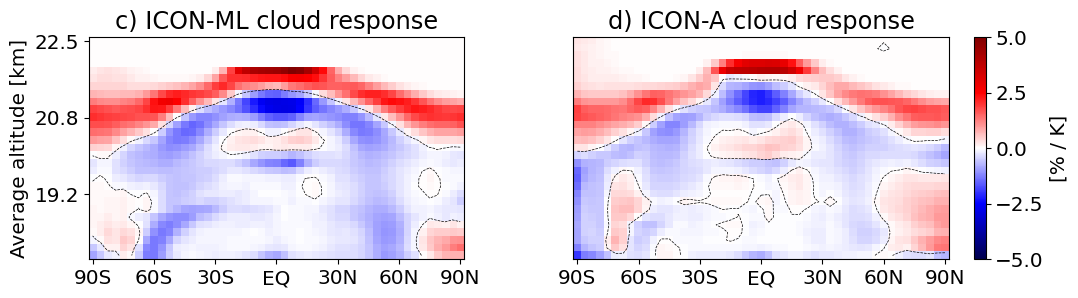

In [68]:
# Set up figure
fig = plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.4, wspace=0.01)
axes = (0,1)

# Define bounds
vmax = np.maximum(np.nanmax(diff_clc_prof_ml), np.nanmax(diff_clc_prof_nat))
vmin = np.minimum(np.nanmin(diff_clc_prof_ml), np.nanmin(diff_clc_prof_nat))

vmax = 5
vmin = -vmax

# Proper tick labeling for x-axis
n = diff_clc_prof_nat.shape[0]
xticks = np.linspace(0, n-1, 7)
xticklabels = ['90S', '60S', '30S', 'EQ', '30N', '60N', '90N']

# Proper tick labeling for y-axis
vgrid = xr.open_mfdataset(paths[key] + '/*vgrid*.nc')
heights = np.mean(vgrid.zg.values, axis=1)[18:]/1000

# ICON-ML
ax = plt.subplot(4, 3, 1)
axis = axes[:0] + axes[1:]
plt1 = ax.imshow(diff_clc_prof_ml.T, cmap='seismic', vmax=vmax, vmin=vmin)
contours = ax.contour(diff_clc_prof_ml.T, levels=[-1e-6], colors='black', linewidths=0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(np.round(heights, 1))
ax.set_ylabel('Average altitude [km]')
ax.set_title('c) ICON-ML cloud response')

# ICON-A 
ax = plt.subplot(4, 3, 2)
axis = axes[:1] + axes[2:]
plt2 = ax.imshow(diff_clc_prof_nat.T, cmap='seismic', vmax=vmax, vmin=vmin)
contours = ax.contour(diff_clc_prof_nat.T, levels=[-1e-6], colors='black', linewidths=0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_title('d) ICON-A cloud response')

# fig.colorbar(plt1)
cbar = fig.colorbar(plt2)
cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
cbar.set_label('[% / K]')

**With Cloud Feedback - only ICON-ML+4K**

Do each of these calculations for both low and nonlow clouds:

SWCRE=rsut−rsutcs <br>
LWCRE=rlutcs-rlut <br>
CRE=SWCRE+LWCRE <br>
SW Cloud Feedback=ΔSWCRE​/ΔT <br>
LW Cloud Feedback=ΔLWCRE​/ΔT <br>
Cloud Feedback=ΔCRE​/ΔT

In [7]:
# Load the required data
data_2d = {}; low_clouds = {}; nonlow_clouds = {}; cre = {}; cre_low = {}; cre_nonlow = {}
for key in ['icon_ml', 'icon_ml_4K']:
    # All 2D data
    data_2d[key] = xr.open_mfdataset(paths[key] + '/*atm_2d_ml*.nc')

    # Compute cloud top pressure of uppermost cloudy cell in each column
    topcld = np.argmax(data_cl[key] > 1e-2, axis=1) # In every column, argmax gives you the first index, for which there is more than 1% cloud fraction
    K, L = topcld.shape
    k_indices = np.arange(K)[:, None]  # Shape (K, 1), to broadcast over L
    l_indices = np.arange(L)
    k_grid, l_grid = np.broadcast_arrays(k_indices, l_indices)
    cltop_pressures = data_pfull[key][k_grid,topcld[k_grid, l_grid],l_grid] # Shape of (241,81920) in Pa

    # Set cltop_pressure = -1 for non-cloudy (<1% summed cloud fraction) columns
    cltop_pressures = np.where(np.sum(data_cl[key], axis=1) < 1e-2, -1, cltop_pressures)

    # Extract low clouds (>680 hPa)
    low_clouds[key] = cltop_pressures > 68000
    nonlow_clouds[key] = (cltop_pressures < 68000) & (0 < cltop_pressures)

    print('Number of low clouds: %d'%np.sum(low_clouds[key]))
    print('Number of nonlow clouds: %d'%np.sum(nonlow_clouds[key]))

    # Compute cloud feedbacks
    swcre = data_2d[key].rsut - data_2d[key].rsutcs
    lwcre = data_2d[key].rlutcs - data_2d[key].rlut
    cre[key] = swcre + lwcre      

    # Split between low and nonlow clouds
    cre_low[key] = np.where(low_clouds[key], cre[key], 0)
    cre_nonlow[key] = np.where(nonlow_clouds[key], cre[key], 0)

# Take the last 10 YEARS
diff_cre_low_icon_ml = np.mean(cre_low['icon_ml_4K'][121:] - cre_low['icon_ml'][121:], axis=0)
diff_cre_nonlow_icon_ml = np.mean(cre_nonlow['icon_ml_4K'][121:] - cre_nonlow['icon_ml'][121:], axis=0)

# Convert to per Kelvin
diff_cre_low_icon_ml = diff_cre_low_icon_ml/4
diff_cre_nonlow_icon_ml = diff_cre_nonlow_icon_ml/4

diff_cre_low_icon_ml_prof = np.ones(49)*1000
diff_cre_nonlow_icon_ml_prof = np.ones(49)*1000
for bin in range(1, 50):
    diff_cre_low_icon_ml_prof[bin - 1] = np.mean(diff_cre_low_icon_ml[bin_ind==bin], axis=0)
    diff_cre_nonlow_icon_ml_prof[bin - 1] = np.mean(diff_cre_nonlow_icon_ml[bin_ind==bin], axis=0)

Number of low clouds: 137576
Number of nonlow clouds: 19474297
Number of low clouds: 179249
Number of nonlow clouds: 19421757


Text(0.5, 1.0, 'b) ICON-ML Cloud Feedback')

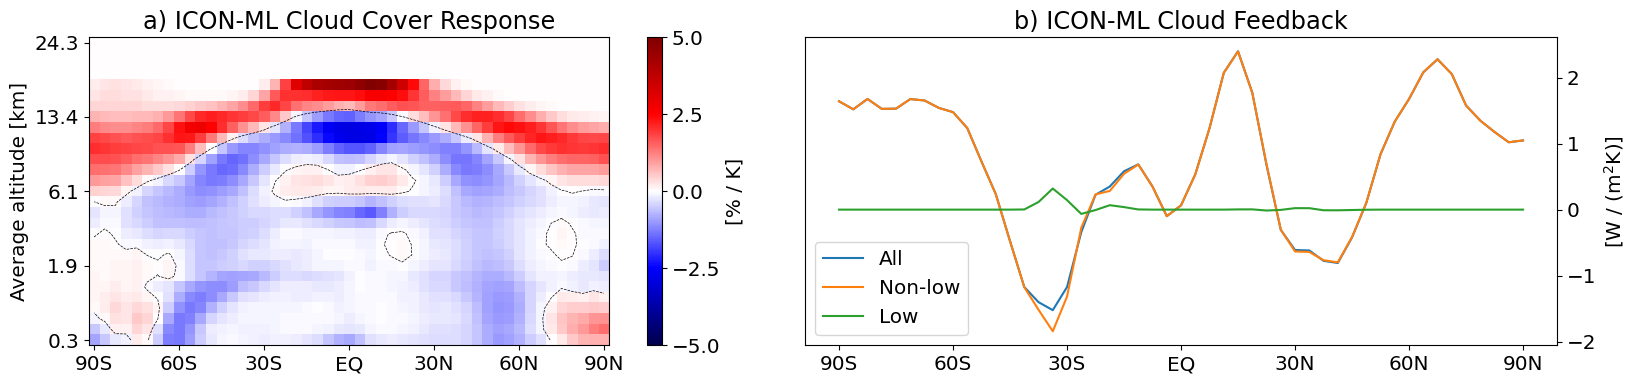

In [90]:
# Set up figure
fig = plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.06)
axes = (0,1)

# Define bounds
vmax = np.ceil(np.nanmax(diff_clc_prof_ml))
vmin = np.floor(np.nanmin(diff_clc_prof_ml))

vmax = np.maximum(vmax, -vmin)
vmin = -np.maximum(-vmin, vmax)

# Proper tick labeling for x-axis
n = diff_clc_prof_nat.shape[0]
xticks = np.linspace(0, n-1, 7)
xticklabels = ['90S', '60S', '30S', 'EQ', '30N', '60N', '90N']

# Proper tick labeling for y-axis
vgrid = xr.open_mfdataset(paths[key] + '/*vgrid*.nc')
heights = np.mean(vgrid.zg.values, axis=1)[18:]/1000
m = diff_clc_prof_nat.shape[1]
yticks = np.linspace(0, m-1, 5).astype(int)
yticklabels = [np.round(heights[yticks[i]], 1) for i in range(len(yticks))]

# ICON-ML Cloud Response
ax = plt.subplot(1, 2, 1)
axis = axes[:0] + axes[1:]
plt1 = ax.imshow(diff_clc_prof_ml.T, cmap='seismic', vmax=vmax, vmin=vmin)
contours = ax.contour(diff_clc_prof_ml.T, levels=[-1e-6], colors='black', linewidths=0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Average altitude [km]')
ax.set_title('a) ICON-ML Cloud Cover Response')

# fig.colorbar(plt1)
cbar = fig.colorbar(plt1)
cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
cbar.set_label('[% / K]')

# ICON-ML Cloud Feedback
ax = plt.subplot(1, 2, 2)
axis = axes[:1] + axes[2:]
ax.plot(diff_cre_low_icon_ml_prof + diff_cre_nonlow_icon_ml_prof)
ax.plot(diff_cre_nonlow_icon_ml_prof)
ax.plot(diff_cre_low_icon_ml_prof)
plt.legend(['All', 'Non-low', 'Low'])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'[W / (m$^2$K)]')
ax.yaxis.tick_right()           # Place ticks on the right side
ax.yaxis.set_label_position("right")  # Set y-axis label position to the right
ax.set_title('b) ICON-ML Cloud Feedback')

**Split between SW and LW Feedback**

In [109]:
# Subtracting in dataarrays
key = 'icon_ml'
A = data_2d[key].rsut.values - data_2d[key].rsutcs.values

B = data_2d[key].rsut - data_2d[key].rsutcs
assert np.all(A == B.values)

assert np.all((np.mean(B, axis=0).values - np.mean(A, axis=0)) < 1e-2)

In [51]:
# Load the required data
data_2d = {}; cre = {}; swcre = {}; lwcre = {}
for key in ['icon_ml', 'icon_ml_4K']:
    # All 2D data
    data_2d[key] = xr.open_mfdataset(paths[key] + '/*atm_2d_ml*.nc')

    # Compute cloud feedbacks
    swcre[key] = data_2d[key].rsut - data_2d[key].rsutcs
    lwcre[key] = data_2d[key].rlutcs - data_2d[key].rlut
    cre[key] = swcre[key] + lwcre[key]

# Take the last 10 YEARS
diff_swcre_icon_ml = np.mean(swcre['icon_ml_4K'][121:] - swcre['icon_ml'][121:], axis=0)
diff_lwcre_icon_ml = np.mean(lwcre['icon_ml_4K'][121:] - lwcre['icon_ml'][121:], axis=0)

# Convert to per Kelvin
diff_swcre_icon_ml = diff_swcre_icon_ml/4
diff_lwcre_icon_ml = diff_lwcre_icon_ml/4

diff_swcre_icon_ml_prof = np.ones(49)*1000
diff_lwcre_icon_ml_prof = np.ones(49)*1000
for bin in range(1, 50):
    diff_swcre_icon_ml_prof[bin - 1] = float(np.mean(diff_swcre_icon_ml[bin_ind==bin], axis=0))
    diff_lwcre_icon_ml_prof[bin - 1] = float(np.mean(diff_lwcre_icon_ml[bin_ind==bin], axis=0))

Text(0.5, 1.0, 'b) Difference in Cloud Radiative Effects')

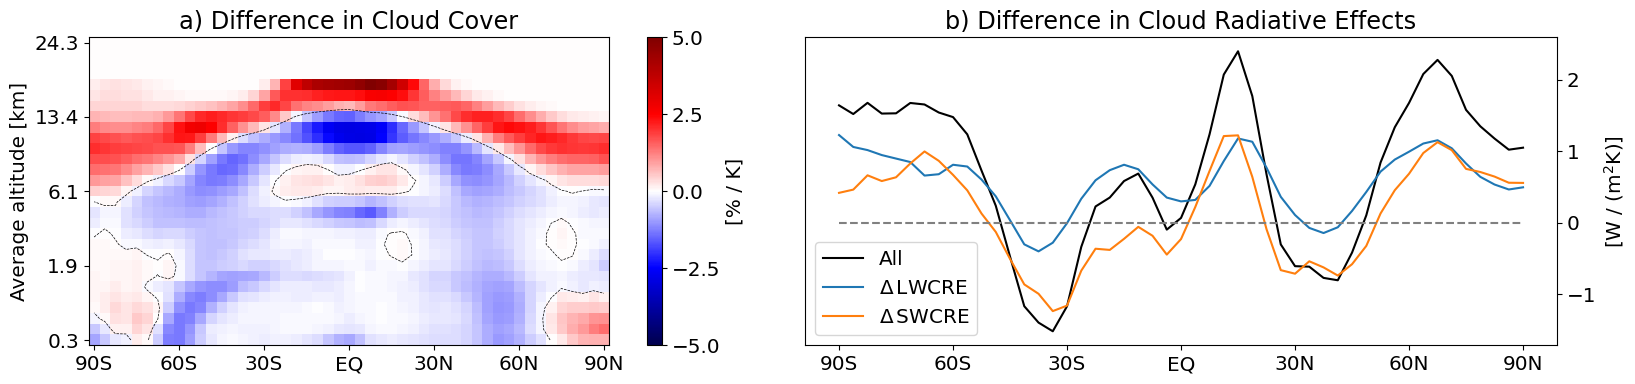

In [91]:
# Set up figure
fig = plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.06)
axes = (0,1)

# Define bounds
vmax = np.ceil(np.nanmax(diff_clc_prof_ml))
vmin = np.floor(np.nanmin(diff_clc_prof_ml))

vmax = np.maximum(vmax, -vmin)
vmin = -np.maximum(-vmin, vmax)

# Proper tick labeling for x-axis
n = diff_clc_prof_nat.shape[0]
xticks = np.linspace(0, n-1, 7)
xticklabels = ['90S', '60S', '30S', 'EQ', '30N', '60N', '90N']
m = diff_clc_prof_nat.shape[1]
yticks = np.linspace(0, m-1, 5).astype(int)
yticklabels = [np.round(heights[yticks[i]], 1) for i in range(len(yticks))]

# Proper tick labeling for y-axis
vgrid = xr.open_mfdataset(paths[key] + '/*vgrid*.nc')
heights = np.mean(vgrid.zg.values, axis=1)[18:]/1000

# ICON-ML Cloud Response
ax = plt.subplot(1, 2, 1)
axis = axes[:0] + axes[1:]
plt1 = ax.imshow(diff_clc_prof_ml.T, cmap='seismic', vmax=vmax, vmin=vmin)
contours = ax.contour(diff_clc_prof_ml.T, levels=[-1e-6], colors='black', linewidths=0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Average altitude [km]')
ax.set_title('a) Difference in Cloud Cover')

# fig.colorbar(plt1)
cbar = fig.colorbar(plt1)
cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
cbar.set_label('[% / K]')

# ICON-ML Cloud Feedback
ax = plt.subplot(1, 2, 2)
axis = axes[:1] + axes[2:]
ax.plot(diff_swcre_icon_ml_prof + diff_lwcre_icon_ml_prof, color='black')
ax.plot(diff_lwcre_icon_ml_prof)
ax.plot(diff_swcre_icon_ml_prof)
ax.hlines(0, xmin=0, xmax=48, ls='--', color='gray')
plt.legend(['All', r'$\Delta\,$LWCRE', r'$\Delta\,$SWCRE'])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'[W / (m$^2$K)]')
ax.yaxis.tick_right()           # Place ticks on the right side
ax.yaxis.set_label_position("right")  # Set y-axis label position to the right
ax.set_title('b) Difference in Cloud Radiative Effects')

Text(0.5, 1.0, 'b) Difference in Cloud Radiative Effects')

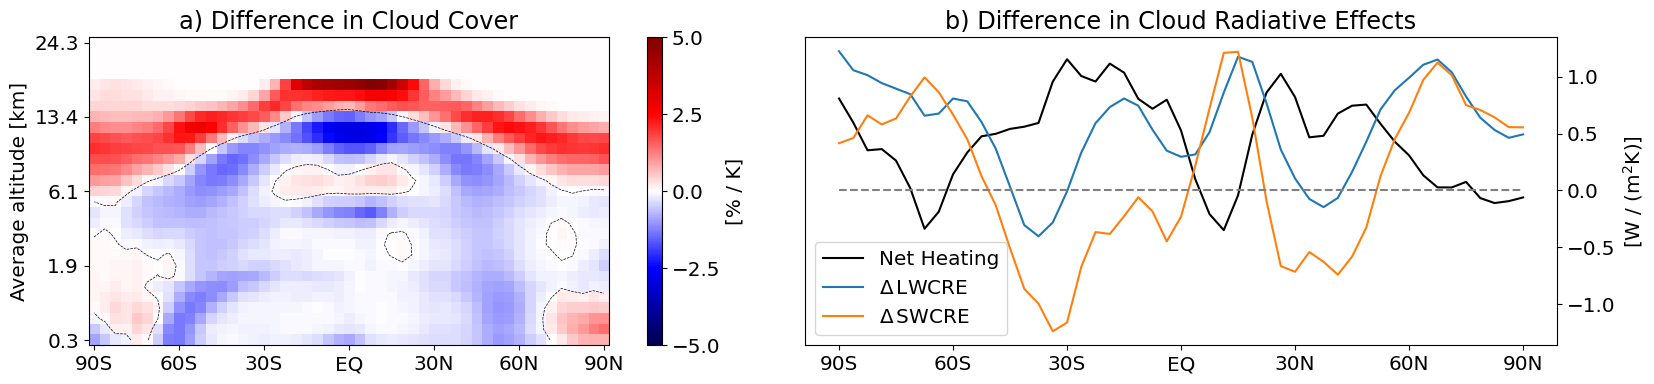

In [92]:
# Set up figure
fig = plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.06)
axes = (0,1)

# Define bounds
vmax = np.ceil(np.nanmax(diff_clc_prof_ml))
vmin = np.floor(np.nanmin(diff_clc_prof_ml))

vmax = np.maximum(vmax, -vmin)
vmin = -np.maximum(-vmin, vmax)

# Proper tick labeling for x-axis
n = diff_clc_prof_nat.shape[0]
xticks = np.linspace(0, n-1, 7)
xticklabels = ['90S', '60S', '30S', 'EQ', '30N', '60N', '90N']

# Proper tick labeling for y-axis
vgrid = xr.open_mfdataset(paths[key] + '/*vgrid*.nc')
heights = np.mean(vgrid.zg.values, axis=1)[18:]/1000
m = diff_clc_prof_nat.shape[1]
yticks = np.linspace(0, m-1, 5).astype(int)
yticklabels = [np.round(heights[yticks[i]], 1) for i in range(len(yticks))]

# ICON-ML Cloud Response
ax = plt.subplot(1, 2, 1)
axis = axes[:0] + axes[1:]
plt1 = ax.imshow(diff_clc_prof_ml.T, cmap='seismic', vmax=vmax, vmin=vmin)
contours = ax.contour(diff_clc_prof_ml.T, levels=[-1e-6], colors='black', linewidths=0.5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Average altitude [km]')
ax.set_title('a) Difference in Cloud Cover')

# fig.colorbar(plt1)
cbar = fig.colorbar(plt1)
cbar.set_ticks([vmin, vmin/2, 0, vmax/2, vmax])
cbar.set_label('[% / K]')

# ICON-ML Cloud Feedback
ax = plt.subplot(1, 2, 2)
axis = axes[:1] + axes[2:]
ax.plot(diff_lwcre_icon_ml_prof - diff_swcre_icon_ml_prof, color='black')
ax.plot(diff_lwcre_icon_ml_prof)
ax.plot(diff_swcre_icon_ml_prof)
ax.hlines(0, xmin=0, xmax=48, ls='--', color='gray')
plt.legend(['Net Heating', r'$\Delta\,$LWCRE', r'$\Delta\,$SWCRE'])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'[W / (m$^2$K)]')
ax.yaxis.tick_right()           # Place ticks on the right side
ax.yaxis.set_label_position("right")  # Set y-axis label position to the right
ax.set_title('b) Difference in Cloud Radiative Effects')

In [76]:
# Net heating overall
# np.mean(diff_lwcre_icon_ml_prof - diff_swcre_icon_ml_prof)
np.mean(diff_lwcre_icon_ml.values) - np.mean(diff_swcre_icon_ml.values)

0.5268711

psyplot.project.Project([    arr4: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

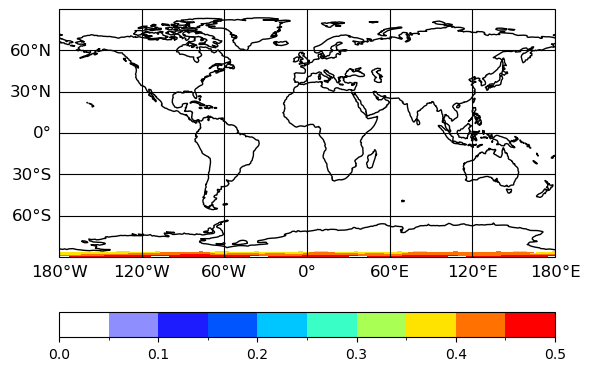

In [54]:
# Double-check whether masking of latitudes was correct

# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

# Plot SW radiation
file_template.clt.values[0] = diff_swcre_icon_ml
for k in range(len(file_template.clt.values[0])):
    if (bin_ind!=1)[k]:
        file_template.clt.values[0][k] = 0
# mean = np.mean(file_template.clt.values[0])
# print('Average change = %.4f'%mean)
psy.plot.mapplot(file_template, name='clt')

Text(0.5, 1.0, 'a) ICON-ML $\\Delta$ Cloud Radiative Effect')

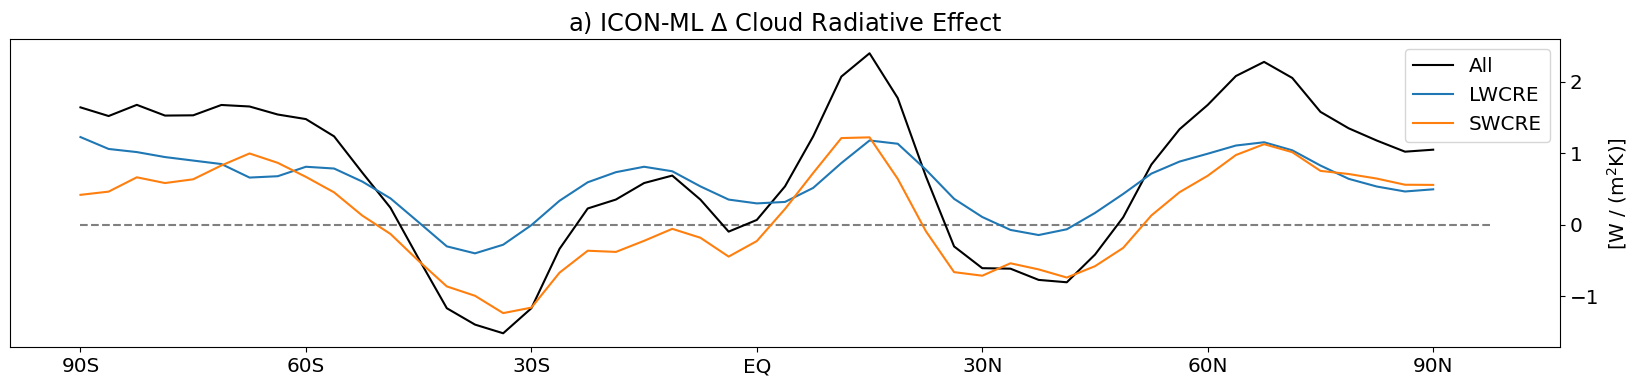

In [35]:
# Set up figure
fig = plt.figure(figsize=(20, 4))
plt.subplots_adjust(hspace=0.4, wspace=0.06)
axes = (0,1)

# Define bounds
vmax = np.ceil(np.nanmax(diff_clc_prof_ml))
vmin = np.floor(np.nanmin(diff_clc_prof_ml))

vmax = np.maximum(vmax, -vmin)
vmin = -np.maximum(-vmin, vmax)

# Proper tick labeling for x-axis
n = diff_clc_prof_nat.shape[0]
xticks = np.linspace(0, n-1, 7)
xticklabels = ['90S', '60S', '30S', 'EQ', '30N', '60N', '90N']

# Proper tick labeling for y-axis
vgrid = xr.open_mfdataset(paths[key] + '/*vgrid*.nc')
heights = np.mean(vgrid.zg.values, axis=1)[18:]/1000

# ICON-ML Cloud Feedback
ax = plt.subplot(1, 1, 1)
axis = axes[:1] + axes[2:]
ax.plot(diff_swcre_icon_ml_prof + diff_lwcre_icon_ml_prof, color='black')
ax.plot(diff_lwcre_icon_ml_prof)
ax.plot(diff_swcre_icon_ml_prof)
ax.hlines(0, xmin=0, xmax=50, ls='--', color='gray')
plt.legend(['All', 'LWCRE', 'SWCRE'])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel(r'[W / (m$^2$K)]')
ax.yaxis.tick_right()           # Place ticks on the right side
ax.yaxis.set_label_position("right")  # Set y-axis label position to the right
ax.set_title(r'a) ICON-ML $\Delta$ Cloud Radiative Effect')

**Compare SW radiation**

In [1]:
import psyplot.project as psy

INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 256 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [79]:
# Load the required data
data_2d = {}; data_rsut = {}; data_rlut = {}; data_clt = {}
for key in keys:
    # All 2D data
    data_2d[key] = xr.open_mfdataset(paths[key] + '/*atm_2d_ml*.nc')
    # Actually only need TOA SW radiation
    data_rsut[key] = data_2d[key].rsut.values
    data_rlut[key] = data_2d[key].rlut.values
    data_clt[key] = data_2d[key].clt.values

In [5]:
# Load some 2D nc-file as a template for plotting
icon_path = '/work/bd1179/b309170/icon-ml_models/icon-a-ml/experiments'
file_nc = icon_path + '/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly/ag_atm_amip_r2b5_cvtfall_entrmid_crt_05_3hourly_atm_2d_ml_19790501T000000Z.nc'
file_template = xr.open_dataset(file_nc)

# Coordinates are not fully recognized by xarray so that we have to add some manually 
coordlist = ["vertices_latitude", "vertices_longitude", "clat_bnds", "clon_bnds"]
file_template = file_template.set_coords([coord for coord in file_template.data_vars if coord in coordlist])

In [7]:
# Take the last 10 YEARS, average in time
diff_rsut_icon_ml = np.mean(data_rsut['icon_ml_4K'][121:] - data_rsut['icon_ml'][121:], axis=0)
diff_rsut_icon_nat = np.mean(data_rsut['icon_nat_4K'][121:] - data_rsut['icon_nat'][121:], axis=0)

Average change = -1.7342


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr28: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

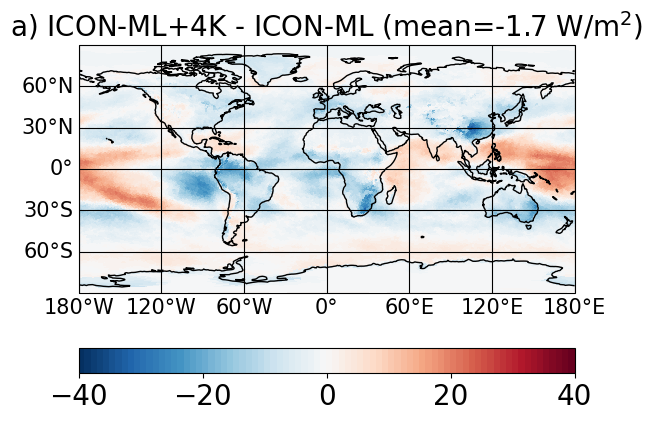

In [70]:
# Plot SW radiation
file_template.clt.values[0] = diff_rsut_icon_ml
mean = np.mean(file_template.clt.values[0])
print('Average change = %.4f'%mean)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'a) ICON-ML+4K - ICON-ML (mean=%.1f W/m$^2$)'%mean, cmap='RdBu_r', cticksize=20, bounds = np.arange(-40,40.01), cticks=np.arange(-40,40.01, 20), titlesize=20, grid_labelsize=15)

Average change = 1.5097


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr27: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

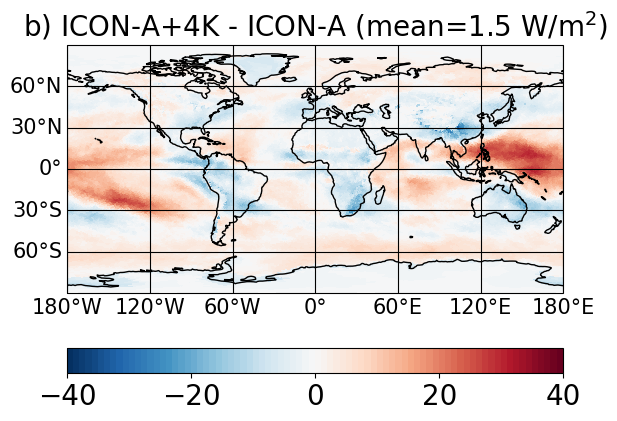

In [69]:
# Plot SW radiation
file_template.clt.values[0] = diff_rsut_icon_nat
mean = np.mean(file_template.clt.values[0])
print('Average change = %.4f'%mean)
psy.plot.mapplot(file_template, name='clt', time = [0], title=r'b) ICON-A+4K - ICON-A (mean=%.1f W/m$^2$)'%mean, cmap='RdBu_r', cticksize=20, bounds = np.arange(-40,40.01), cticks=np.arange(-40,40.01, 20), titlesize=20, grid_labelsize=15)


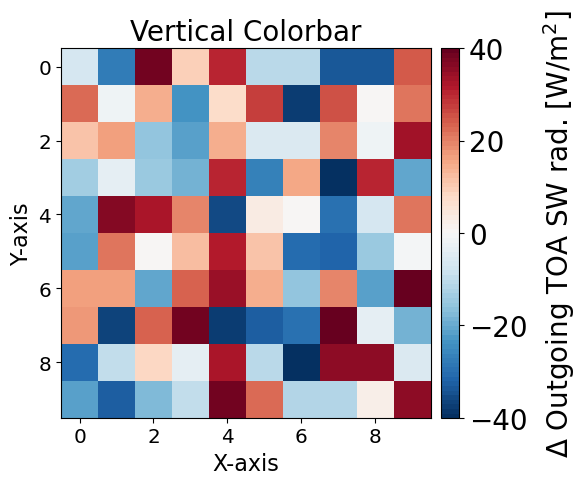

In [78]:
# To get a vertical colorbar

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Sample data to display (10x10 grid with values between -40 and 40)
data = np.random.uniform(-40, 40, size=(10, 10))

# Create a figure and axis
fig, ax = plt.subplots()

# Create a normalized colormap
cmap = plt.get_cmap('RdBu_r')
bounds = np.arange(-40, 41, 1)  # Define bounds for color mapping
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# Plot the data
cax = ax.imshow(data, cmap=cmap, norm=norm)

# Create a vertically oriented colorbar with specified parameters
cbar = fig.colorbar(cax, ax=ax, ticks=np.arange(-40, 41, 20), orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=20)  # Set color tick size
cbar.set_label(r'$\Delta$ Outgoing TOA SW rad. [W/m$^2$]', fontsize=20, labelpad=10)  # Optional: label for the colorbar

# Set title and labels for the main plot
ax.set_title('Vertical Colorbar', fontsize=20)
ax.set_xlabel('X-axis', fontsize=16)
ax.set_ylabel('Y-axis', fontsize=16)

# Display the plot
plt.show()

**Compare LW radiation**

In [21]:
# Take the last 10 YEARS, average in time
diff_rlut_icon_ml = np.mean(data_rlut['icon_ml_4K'][121:] - data_rlut['icon_ml'][121:], axis=0)
diff_rlut_icon_nat = np.mean(data_rlut['icon_nat_4K'][121:] - data_rlut['icon_nat'][121:], axis=0)

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr12: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

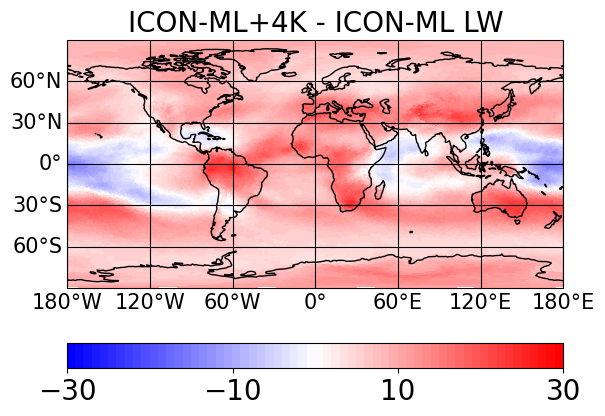

In [26]:
# Plot SW radiation
file_template.clt.values[0] = diff_rlut_icon_ml
# print('RMSE = %.4f'%np.sqrt(np.mean((file_template.clt.values[0])**2)))
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-ML+4K - ICON-ML LW', cmap='bwr', bounds = np.arange(-30,30.01), cticks=np.arange(-30,30.01, 20),  cticksize=20, titlesize=20, grid_labelsize=15)

/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr13: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

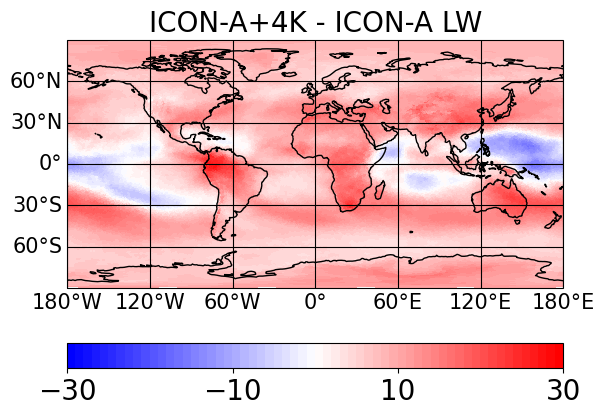

In [27]:
# Plot SW radiation
file_template.clt.values[0] = diff_rlut_icon_nat
# print('RMSE = %.4f'%np.sqrt(np.mean((file_template.clt.values[0])**2)))
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-A+4K - ICON-A LW', cmap='bwr', cticksize=20, bounds = np.arange(-30,30.01), cticks=np.arange(-30,30.01, 20),  titlesize=20, grid_labelsize=15)

**Compare total cloud cover**

In [80]:
# Take the last 10 YEARS, average in time
diff_clt_icon_ml = np.mean(data_clt['icon_ml_4K'][121:] - data_clt['icon_ml'][121:], axis=0)
diff_clt_icon_nat = np.mean(data_clt['icon_nat_4K'][121:] - data_clt['icon_nat'][121:], axis=0)

Average change = -0.0165


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr35: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

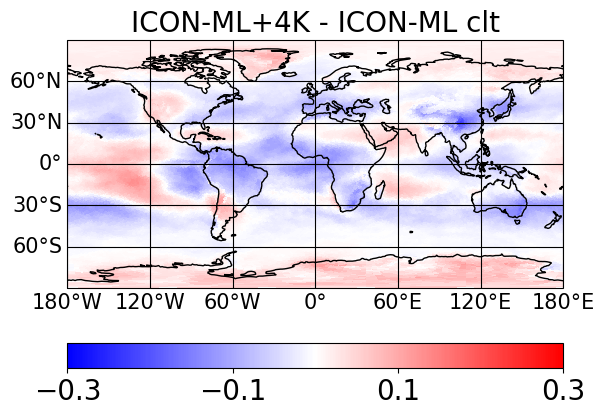

In [93]:
# Plot total cloud cover
file_template.clt.values[0] = diff_clt_icon_ml
mean = np.mean(file_template.clt.values[0])
print('Average change = %.4f'%mean)
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-ML+4K - ICON-ML clt', cmap='bwr',bounds = np.arange(-0.3, 0.301, 0.002), cticks=np.arange(-0.3, 0.301, 0.2), cticksize=20, titlesize=20, grid_labelsize=15)

Average change = -0.0006


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/psy_simple/plugin.py:251: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if b is None or b == 'none':


psyplot.project.Project([    arr36: 1-dim DataArray of clt, with (ncells)=(81920,), time=1.979e+07])

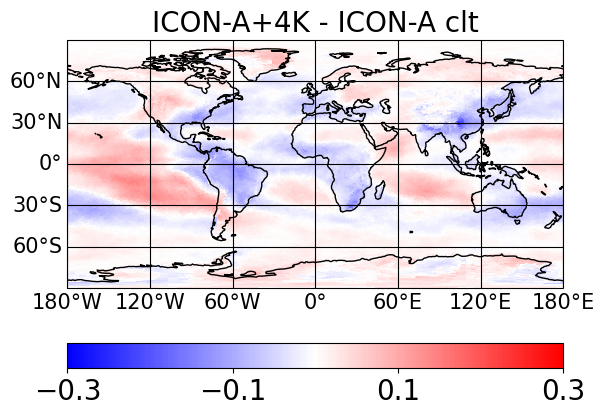

In [95]:
# Plot total cloud cover
file_template.clt.values[0] = diff_clt_icon_nat
mean = np.mean(file_template.clt.values[0])
print('Average change = %.4f'%mean)
psy.plot.mapplot(file_template, name='clt', time = [0], title='ICON-A+4K - ICON-A clt', cmap='bwr',bounds = np.arange(-0.3, 0.301, 0.002), cticks=np.arange(-0.3, 0.301, 0.2), cticksize=20, titlesize=20, grid_labelsize=15)